# Importing Libraries

In [72]:
import os
from PIL import Image
from random import shuffle
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
import torch.nn.functional as F
import shap


In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Dataloader

In [4]:
class CancerDataset(Dataset):
    def __init__(self, root = "", shuffle_ = False, transform = None):
        self.img_paths = []
        benign_img_paths = os.listdir(root+'/' + 'Benign/')
        benign_img_paths = [root+'/Benign/' + img_path for img_path in benign_img_paths]
        malignant_img_paths = os.listdir(root+'/' + 'Malignant/')
        malignant_img_paths = [root+'/Malignant/' + img_path for img_path in malignant_img_paths]
        self.img_paths = benign_img_paths + malignant_img_paths
        self.transform = transform
        
        if shuffle_:
            shuffle(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        c_type = img_path.split('/')[-1].split('.')[0]

        if 'B' in c_type:
            label = 0
        elif 'M' in c_type:
            label = 1
        
        return img, torch.tensor(label)

    def __len__(self):
        return len(self.img_paths)

In [5]:
root_train = 'Dataset/Train'
root_test = 'Dataset/Test'

In [6]:
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [7]:
train_data = CancerDataset(root=root_train, shuffle_= True, transform= transform)
test_data = CancerDataset(root = root_test, shuffle_=False, transform=transform)

In [8]:
train_dataloader = DataLoader(dataset=train_data,  batch_size = 32, shuffle=True)
test_dataloader = DataLoader(dataset = test_data,batch_size = 32)

torch.Size([32, 3, 224, 224])
torch.Size([32])


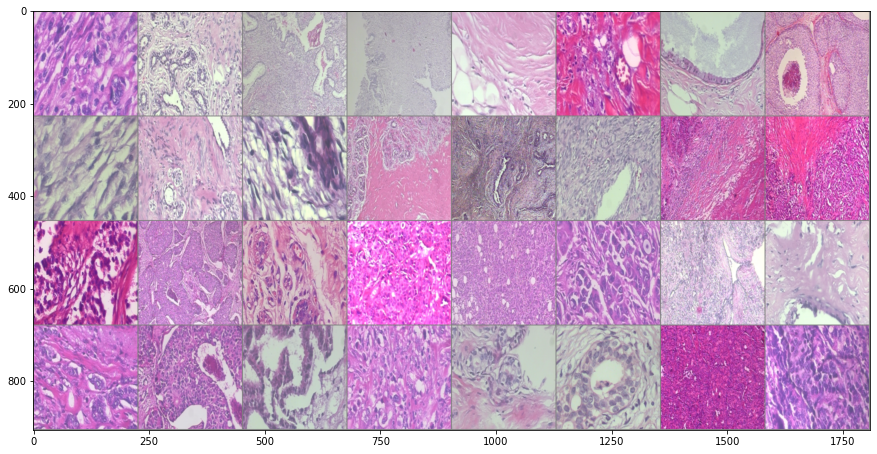

<Figure size 1080x1296 with 0 Axes>

In [9]:
def imshow(img):

  img = img / 2 + 0.5 
  npimg = img.numpy() 
  plt.figure(figsize=(15,18))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.figure(figsize=(15,18))
  plt.show()

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

imshow(torchvision.utils.make_grid(images))

# Backbone

In [12]:
net = models.vgg16_bn(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier[6] = nn.Linear(4096, 2)

In [18]:
summary(net, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

# Training the model

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)

In [21]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'model.pth')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/57], Loss: 0.7295
Epoch [1/5], Step [20/57], Loss: 0.5774
Epoch [1/5], Step [40/57], Loss: 0.7994

train-loss: 0.6682, train-acc: 84.7778
validation loss: 0.5328, validation acc: 93.0000

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/57], Loss: 0.3549
Epoch [2/5], Step [20/57], Loss: 0.3786
Epoch [2/5], Step [40/57], Loss: 0.1668

train-loss: 0.5277, train-acc: 91.7778
validation loss: 0.6630, validation acc: 90.5000

Epoch 3

Epoch [3/5], Step [0/57], Loss: 1.3654
Epoch [3/5], Step [20/57], Loss: 0.4071
Epoch [3/5], Step [40/57], Loss: 1.1558

train-loss: 0.5094, train-acc: 91.3333
validation loss: 0.5956, validation acc: 92.0000

Improvement-Detected, save-model
Epoch 4

Epoch [4/5], Step [0/57], Loss: 0.3035
Epoch [4/5], Step [20/57], Loss: 0.5038
Epoch [4/5], Step [40/57], Loss: 1.2821

train-loss: 0.5036, train-acc: 90.8333
validation loss: 0.6371, validation acc: 93.0000

Epoch 5

Epoch [5/5], Step [0/57], Loss: 1.0310
Epoch [5/5], S

In [39]:
test_data = CancerDataset(root = root_test, shuffle_=False, transform=transform)
test_dataloader = DataLoader(dataset = test_data,batch_size = 128, shuffle = True)


In [40]:
batch = next(iter(test_dataloader ))
images, _ = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Malignant


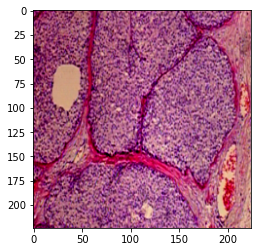

In [69]:
plt.imshow(np.transpose(images[100], (1, 2, 0)))
label_1 = 'Bengin' if _[100].item()==0 else 'Malignant' 
print(label_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bengin


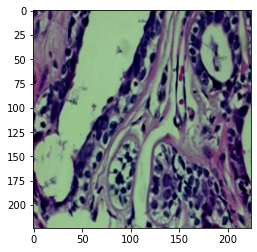

In [70]:
plt.imshow(np.transpose(images[101], (1, 2, 0)))
label_2 = 'Bengin' if _[101].item()==0 else 'Malignant' 
print(label_2)

In [64]:
images.shape

torch.Size([128, 3, 224, 224])

# Using Explainable AI (XAI)

In [44]:
batch = next(iter(test_dataloader ))
images, _ = batch

background = images[:100]
test_images = images[100:102]

e = shap.DeepExplainer(net, background)
shap_values = e.shap_values(test_images)

In [45]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


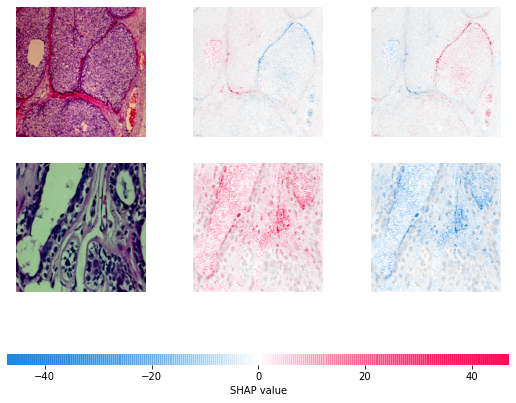

Img one is Malignant
Img two is Bengin


In [71]:
#shap signatures
shap.image_plot(shap_numpy, test_numpy)
print('Img one is {}'.format(label_1))
print('Img two is {}'.format(label_2))